In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
import wandb

wandb.login()

run = wandb.init(
    # Set the project where this run will be logged
    project="my-awesome-project",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": 0.001,
        "epochs": 10,
    },
)

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: krystianglod7 (krystianglod7-agh). Use `wandb login --relogin` to force relogin


In [3]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=tensor_transform)

# DataLoader is used to load the dataset for training
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

1.2%

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




8.9%

100.0%
100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# Creating a PyTorch class
# 28*28 ==> 8 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 8
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 8 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

In [6]:
epochs = 10
outputs = []
losses = []
for epoch in range(epochs):
    print("Epoch: ", epoch)
    for image, _ in loader:

        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28 * 28)

        # Output of Autoencoder
        reconstructed = model(image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss.item())

        wandb.log({"loss": loss})


    outputs.append((epochs, image, reconstructed))
    print("Loss", loss.item())

Epoch:  0
Loss 0.022916994988918304
Epoch:  1
Loss 0.028152480721473694
Epoch:  2
Loss 0.020567933097481728
Epoch:  3
Loss 0.021519944071769714
Epoch:  4
Loss 0.023004936054348946
Epoch:  5
Loss 0.021478382870554924
Epoch:  6
Loss 0.0207070242613554
Epoch:  7
Loss 0.01896856352686882
Epoch:  8
Loss 0.020937997847795486
Epoch:  9
Loss 0.020261330530047417


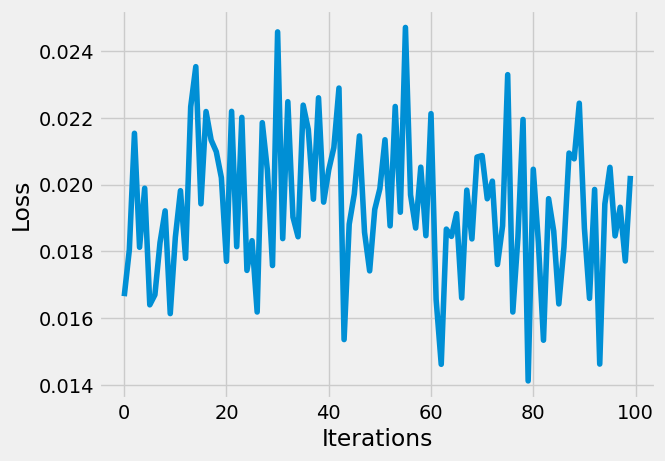

In [7]:
# Defining the Plot Style
plt.style.use("fivethirtyeight")
plt.xlabel("Iterations")
plt.ylabel("Loss")

# Plotting the last 100 values
plt.plot(losses[-100:])

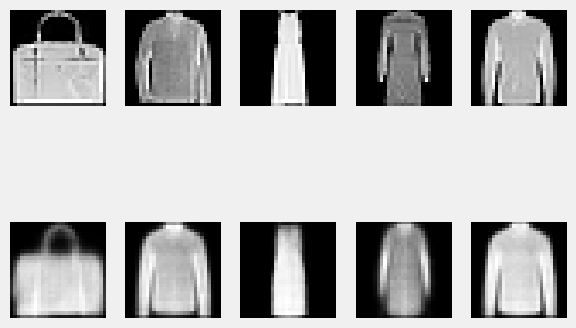

In [8]:
example = image[:5].cpu().detach().numpy()
reconstructed_example = reconstructed[:5].cpu().detach().numpy()

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(example[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_example[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

plt.show()